# PyTorch Feed-Forward Neural Network

## Dataset: Did it Rain in Seattle? (1948-2017)

Kaggle Dataset Web Link:

https://www.kaggle.com/datasets/rtatman/did-it-rain-in-seattle-19482017

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, default_collate
import torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn import metrics

# Hyperparameters

In [2]:
# Hyperparameters
input_layer = 4        # Sets the number of parameters in the input layer
hiddel_layer_1 = 7     # Sets the number of parameters in hidden layer 1
hiddel_layer_2 = 7     # Sets the number of parameters in hidden layer 2
output_layer = 1       # Sets the number of parameters in the output layer
lr = 1e-3              # Sets the leanring rate
epochs = 60            # Sets the number of training epochs
batch_size = 32        # Sets the batch size
# -----------------

# Set the Device to a GPU or CPU

In [3]:
# If a GPU is available use cuda or use the CPU if not available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prints out the available processing device to the screen
device

'cpu'

# Load the Training Dataset

In [4]:
# Read in the data as Pandas DataFrames and convert to NumPy arrays
X = pd.read_csv("./output_csv_data/X_train", header=None).values
y = pd.read_csv("./output_csv_data/y_train", header=None).values

# Prints out the features X to the screen
X

array([[-0.33544152,  1.60300718, -0.85914999, -0.49061759],
       [ 0.08653505, -0.50349486,  1.38519235,  1.11730809],
       [-0.56700083, -0.05788866,  0.50348643,  0.42819709],
       ...,
       [-0.98586469,  0.20084116, -0.93930507, -0.37576575],
       [ 0.96188608, -0.05788866, -0.05759915,  0.31334525],
       [-0.66741989,  2.86286076,  0.34317626,  0.77275259]])

In [5]:
# Reshapes the target classes y
y.reshape(-1, 1)

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

# CSV Dataset Object

In [6]:
# CSVDataset Python class object
class CSVDataset(Dataset):
    
    """CSVDataset PyTorch dataset.
       Args:
       X (NumPy Array): Features of the CSV dataset
       y (NumPy Array): Targets of the CSV dataset
    """
    
    # CSVDataset class constructor
    def __init__(self, X, y):
        # Converts the features and targets into PyTorch tensors
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    # Python method to measure the lenght of the dataset
    def __len__(self):
        return len(self.X)

    # Python method to get an item from the dataset
    def __getitem__(self, idx):
        
        # Gets one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        
        # Returns the features and the targets of the CSV dataset
        return features, target

# Create PyTorch DataLoaders

In [7]:
# Stores the CSVDataset object in the dataset Python variable
dataset = CSVDataset(X, y)

# Randomly slits the training and validation dataset
trainset, valset = random_split(dataset, [0.8, 0.2])

# Creates the training and validation PyTorch DataLoaders
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(valset, shuffle=False, batch_size=batch_size)

# PyTorch FNN Model Object

In [8]:
# FNN PyTorch Neural Netwrk Model
class FNN(nn.Module):
    
    """Feed Forward Neural Network (FNN) object.
       Args:
       input_layer (tensor): Sets the number of neurons in the input layer.
       hiddel_layer_1 (tensor): Sets the number of neurons in the 1st hidden layer.
       hiddel_layer_2 (tensor): Sets the number of neurons in the 2nd hidden layer.
       output_layer (tensor): Sets the number of neurons in the output layer.
    """
    
    # FNN class constructor
    def __init__(self, input_layer, hiddel_layer_1, hiddel_layer_2, output_layer):
        super().__init__()
        
        # FNN class attributes
        self.fc1 = nn.Linear(input_layer, hiddel_layer_1)
        self.fc2 = nn.Linear(hiddel_layer_1, hiddel_layer_2)
        self.output = nn.Linear(hiddel_layer_2, output_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # Python forward method to control the forward pass of the FNN object
    def forward(self, x):
        
        # PyTorch FNN neural network layers and activation functions
        x = self.fc1(x)      # Input layer
        x = self.relu(x)
        x = self.fc2(x)      # Hidden Layer 1
        x = self.relu(x)
        x = self.fc2(x)      # Hidden Layer 2
        x = self.relu(x)
        x = self.output(x)   # Output layer
        x = self.sigmoid(x)
        
        # Returns the output results of the FNN object
        return x

# Initialise the FNN Model

In [9]:
# Defines the FNN PyTorch model
model = FNN(input_layer=input_layer,
            hiddel_layer_1=hiddel_layer_1,
            hiddel_layer_2=hiddel_layer_2,
            output_layer=output_layer)

# Pritns out the FNN model architecture to the screen
print(model)

FNN(
  (fc1): Linear(in_features=4, out_features=7, bias=True)
  (fc2): Linear(in_features=7, out_features=7, bias=True)
  (output): Linear(in_features=7, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


# Optimiser and Loss Function

In [10]:
# Defines the Binary Cross Entropy loss functions and AdamW optimisation algorithm
loss_fn = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Make Model Checkpoint Filepath Directory if Required

In [11]:
# Python method to check for and create a model file path directory
def makedir(path):
    
    """Checks for a file path directory and makes one if required."""

    # File path directory to check for
    file = pathlib.Path(path)

    # Conditional if statement to check for the model checkpoint filep ath directory
    if file.exists():
        # Prints out the file path directory exists if it does and passes the conditional
        print('File path exists: ', path)
        pass
    else:
        # Outputs the folder contents to checkpoint saved models to
        os.makedirs(path)

In [12]:
# Checkpoint file path directory
path = './pytorch-model/'

# Calls the makedir Python method
makedir(path)

# Accuracy Python Method

In [13]:
# Python method to calculate trianing and validation accuracy
def accuracy(y_pred, y_batch):
    
    """Calcuates the trianing and validaiton accuracy."""
    
    # Retuns the calculated accuracy value
    return (y_pred.round() == y_batch).float().mean()

# Training Loop

In [14]:
# Sets the random seed to repeat any randomness
torch.random.manual_seed(1234)

# Sets the FNN model to training mode and to activate backpropagation
model.train()

# Python lists to store the training and validation losses and accuracies for plotting
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

# Variables for model checkpointing
low_loss = 1000
file_name = None

# Training loop to control the number of training epochs
for epoch in range(epochs):
    
    # Prints out the epoch number to the screen during training
    print(f"Epoch {epoch+1}")
    print("----------------")
    
    # Stores the accumulative training loss and accuracy
    train_loss, train_acc = 0, 0
    
    # Loads the training data batches to the model
    for i, train_data in enumerate(train_loader):
        
        # Unpack the training data features and target classes
        X_batch, y_batch = train_data
        
        # Sends the training data features and target classes to the device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Stores the predictions from the FNN model
        y_pred = model(X_batch)
        
        # Calculates the training loss for the batch during training
        loss = loss_fn(y_pred, y_batch)
        
        # Activates backpropagation after calculating the training loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calcualtes the training accuracy for the batch during training
        acc = accuracy(y_pred, y_batch)
        
        # Accumulates the training loss and accuracy
        train_loss += loss
        train_acc += acc
        
    
    # Calculates the training loss and accuracy for the epoch
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    
    # Appends the training loss and accuracy to their respective list for plotting
    train_losses.append(train_loss.item())
    train_accuracy.append(train_acc.item())
    
    # Prints out the training loss and accuracy to the screen
    print(f"Taining Loss {train_loss}% Training Accuracy {train_acc*100:.3f}%")
    
    # Freezes the model gradients for validation
    model.eval()
    
    # Stores the validation loss and accuracy
    val_loss, val_acc = 0, 0
    
    # Loads the validation batches to the model
    for j, val_data in enumerate(val_loader):
        
        # Unpacks the validation features and target classes
        X_batch, y_batch = val_data
        
        # Sends the validation features and target classes to the device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Stores the validation predictions from the model
        y_pred = model(X_batch)
        
        # Calculates the validation loss for the batch
        loss = loss_fn(y_pred, y_batch)
        
        # Calculates the validation accuracy for the batch
        acc = accuracy(y_pred, y_batch)
        
        # Accumulates the validation loss and accuracy
        val_loss += loss
        val_acc += acc
        
    # Accumulates the validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    # Appends the validation loss and accuracy to their respective list for plotting
    val_losses.append(val_loss.item())
    val_accuracy.append(val_acc.item())
    
    # Prints out the validation loss and accuracy to the screen
    print(f"Validation Loss {val_loss}% Validation Accuracy {val_acc*100:.3f}%")
    print("\n")
    
    # Save the FNN model with the lowest validation loss
    if val_loss < low_loss:
        
        # Update the low_loss variable with the lowest validation loss
        low_loss = val_loss
        
        # Conditional if statement to and remove a model with a higher loss if required
        if file_name == None:
            # Passes if the file name is equal to none
            pass
        else:
            # Removes the file name of the model with the higher validation loss
            os.remove(file_name)
            
        # Model checkpoint file path directory
        model_path = path + f'epoch-{epoch+1}.pth'
        
        # Saves the model with PyTorch
        torch.save(model, model_path)
        
        # Sets the file_name variable to the model path
        file_name = model_path

Epoch 1
----------------
Taining Loss 0.5106037855148315% Training Accuracy 76.221%
Validation Loss 0.22019727528095245% Validation Accuracy 91.454%


Epoch 2
----------------
Taining Loss 0.15281274914741516% Training Accuracy 94.543%
Validation Loss 0.11019565165042877% Validation Accuracy 95.940%


Epoch 3
----------------
Taining Loss 0.08042767643928528% Training Accuracy 97.210%
Validation Loss 0.06032175570726395% Validation Accuracy 97.470%


Epoch 4
----------------
Taining Loss 0.04471518099308014% Training Accuracy 98.592%
Validation Loss 0.03221643716096878% Validation Accuracy 99.213%


Epoch 5
----------------
Taining Loss 0.024742579087615013% Training Accuracy 99.659%
Validation Loss 0.0175319854170084% Validation Accuracy 99.936%


Epoch 6
----------------
Taining Loss 0.013570139184594154% Training Accuracy 99.973%
Validation Loss 0.009892040863633156% Validation Accuracy 100.000%


Epoch 7
----------------
Taining Loss 0.007741074543446302% Training Accuracy 99.984%


Taining Loss 5.882076266061631e-07% Training Accuracy 100.000%
Validation Loss 5.02882926411985e-07% Validation Accuracy 100.000%


Epoch 54
----------------
Taining Loss 6.343618110804528e-07% Training Accuracy 100.000%
Validation Loss 5.445812121251947e-07% Validation Accuracy 100.000%


Epoch 55
----------------
Taining Loss 6.571060566784581e-07% Training Accuracy 100.000%
Validation Loss 5.446453315016697e-07% Validation Accuracy 100.000%


Epoch 56
----------------
Taining Loss 6.662883720309765e-07% Training Accuracy 100.000%
Validation Loss 6.561843406416301e-07% Validation Accuracy 100.000%


Epoch 57
----------------
Taining Loss 6.807896966165572e-07% Training Accuracy 100.000%
Validation Loss 6.665034106845269e-07% Validation Accuracy 100.000%


Epoch 58
----------------
Taining Loss 7.658605909455218e-07% Training Accuracy 100.000%
Validation Loss 7.690260304116237e-07% Validation Accuracy 100.000%


Epoch 59
----------------
Taining Loss 7.723760973021854e-07% Training Ac

# Training and Validation Loss

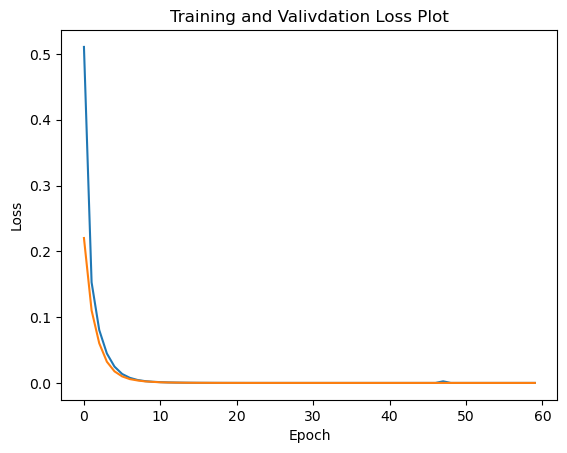

In [15]:
# Plots the training and validation loss curves
plt.title('Training and Valivdation Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.show()

# Training and Validation Accuracy

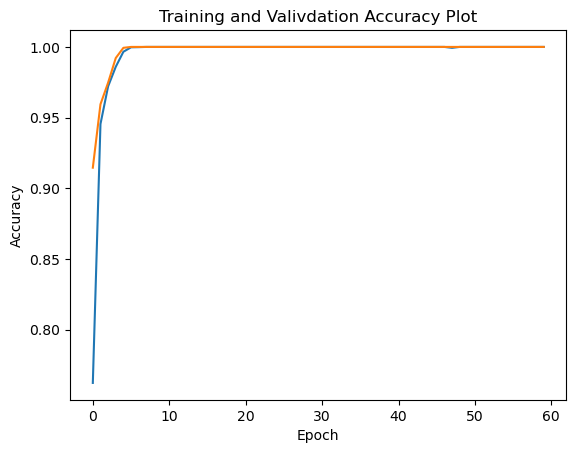

In [16]:
# Plots the training and validation accuracy curves
plt.title('Training and Valivdation Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.show()

# Print out all the Python Variables from the Jupyter Notebook to the Screen

In [17]:
# Prints out all the Python variables to the screen
%whos

Variable                Type          Data/Info
-----------------------------------------------
CSVDataset              type          <class '__main__.CSVDataset'>
ConfusionMatrix         ABCMeta       <class 'torchmetrics.clas<...>_matrix.ConfusionMatrix'>
DataLoader              type          <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                 type          <class 'torch.utils.data.dataset.Dataset'>
FNN                     type          <class '__main__.FNN'>
X                       ndarray       23436x4: 93744 elems, type `float64`, 749952 bytes (732.375 kb)
X_batch                 Tensor        tensor([[-0.5412,  0.1430<...>3415, -1.0195, -0.7203]])
acc                     Tensor        tensor(1.)
accuracy                function      <function accuracy at 0x79acf3317560>
batch_size              int           32
classification_report   function      <function classification_<...>report at 0x79acf6f52d40>
dataset                 CSVDataset    <__main__.CSVDatase